#Final Project

###Import package

In [1]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Layer
from tensorflow.keras.initializers import Constant
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, CuDNNLSTM, Bidirectional, Input, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###Load data

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip glove*.zip
!unzip wiki-news-300d-1M.vec.zip
!wget https://dl.dropboxusercontent.com/s/mll1vn14zqcb1os/train.csv
!wget https://dl.dropboxusercontent.com/s/607wpoldwv10xn3/test.csv

--2019-07-08 13:55:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-07-08 13:55:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-07-08 13:55:21--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

##Exploratory Data Analysis

###Check distribution of target

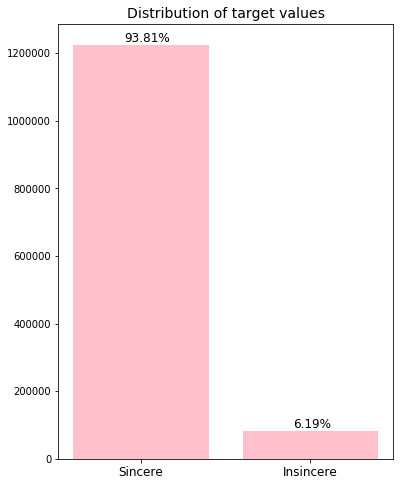

In [4]:
target = train['target']
values_count = list(target.value_counts())
tar = ('Sincere', 'Insincere')

fig, ax = plt.subplots(figsize = (6, 8))
ax.bar([0, 1], values_count, align = 'center', color = 'pink')
ax.text(-0.1, values_count[0] + 10000, s = str(round(values_count[0] * 100 / len(target), 2)) + '%', fontsize = 12)
ax.text(0.9, values_count[1] + 10000, s = str(round(values_count[1] * 100 / len(target), 2)) + '%', fontsize = 12)
ax.set_xticks([0, 1])
ax.set_xticklabels(tar, fontsize = 12)
ax.set_title("Distribution of target values", fontsize = 14)
plt.savefig("/content/Distribution_of_target.png")
plt.show()

In [0]:
train.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

###Check length of questions

In [0]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split(" "))))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split(" "))))))
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))
print('Average word length of sincere questions in train is {0:.0f}.'.format(np.mean(train['question_text'][train['target'] == 0].apply(lambda x: len(x.split())))))
print('Average word length of insincere questions in train is {0:.0f}.'.format(np.mean(train['question_text'][train['target'] == 1].apply(lambda x: len(x.split())))))
print('Max word length of sincere questions in train is {0:.0f}.'.format(np.max(train['question_text'][train['target'] == 0].apply(lambda x: len(x.split())))))
print('Max word length of insincere questions in train is {0:.0f}.'.format(np.max(test['question_text'][train['target'] == 1].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.
Max word length of questions in train is 122.
Max word length of questions in test is 87.
Average character length of questions in train is 71.
Average character length of questions in test is 71.
Average word length of sincere questions in train is 13.
Average word length of insincere questions in train is 17.
Max word length of sincere questions in train is 134.
Max word length of insincere questions in train is 87.


In [0]:
words_questions = np.sort(train['question_text'].apply(lambda x: len(x.split(' '))).values)
len_questions = np.sort(train['question_text'].apply(lambda x: len(x)).values)

top_min_len_questions = [np.where(train['question_text'].apply(lambda x: len(x)) == i) for i in len_questions[:5]]
top_max_len_questions = [np.where(train['question_text'].apply(lambda x: len(x)) == i) for i in len_questions[-5:]]

top_min_num_word_questions = [np.where(train['question_text'].apply(lambda x: len(x.split(' '))) == i) for i in words_questions[:5]]
top_max_num_word_questions = [np.where(train['question_text'].apply(lambda x: len(x.split(' '))) == i) for i in words_questions[-5:]]

In [105]:
for j in range(5):
    for i in top_max_len_questions[j][0]:
        print("Question: {}".format(train['question_text'].values[i]))
        print("Length of question: {}".format(len(train['question_text'].values[i])))
        print("Target: {}\n-----------------------------------------------------------------------".format(train['target'].values[i]))


Question: To you, does being a Christian mean  inviting in the spirit of Jesus into you and suppressing our own spirit? 'Thy will not mine' and all that? Do you like living as a zombie of someone else's spirit - however perfect it may be? Don't you want to experience and improve your own will and spirit and live your life as you, not Jesus?
Length of question: 332
Target: 1
-----------------------------------------------------------------------
Question: What is the answer to [math]\frac{422}{2262\mid 5501}\int{846}^{}\frac{\Omega}{256}\int{2551\times 5942}^{4366+1736}\frac{993+548}{1491\mid 8813}\int{\int{}^{6x + 35}}^{8613-4985}\frac{5509-2038}{436\mid 5018}\int{\Omega}^{3984\mid 3274}\frac{3211-991}{\int{895-4864}^{517}}\int{406+910}^{\int{8672-6582}^{\mathbb{Z}}}\frac{\int{33x + 17}^{218}}{818\mid 1124}\int{790-6578}^{6575+3181}\frac{\oint{\int{\frac{9455+8322}{\oint{448}^{5013-7921}}}^{3451+756}}^{2181-7743}}{1406-3695}\frac{157}{5426-6986} [/math]?
Length of question: 509
Target:

In [102]:
for j in range(len(top_min_len_questions)):
    for i in top_min_len_questions[j][0]:
        print("Question: {}".format(train['question_text'].values[i]))
        print("Length of question: {}".format(len(train['question_text'].values[i])))
        print("Target: {}\n-----------------------------------------------------------------------".format(train['target'].values[i]))


Question: "
Length of question: 1
Target: 1
-----------------------------------------------------------------------
Question: W
Length of question: 1
Target: 1
-----------------------------------------------------------------------
Question: "
Length of question: 1
Target: 1
-----------------------------------------------------------------------
Question: W
Length of question: 1
Target: 1
-----------------------------------------------------------------------
Question: Is 
Length of question: 3
Target: 1
-----------------------------------------------------------------------
Question: If 
Length of question: 3
Target: 1
-----------------------------------------------------------------------
Question: Do 
Length of question: 3
Target: 1
-----------------------------------------------------------------------
Question: Is 
Length of question: 3
Target: 1
-----------------------------------------------------------------------
Question: If 
Length of question: 3
Target: 1
------------------

In [103]:
for j in range(len(top_max_num_word_questions)):
    for i in top_max_num_word_questions[j][0]:
        print("Question: {}".format(train['question_text'].values[i]))
        print("Number of word in question: {}".format(len(train['question_text'].values[i].split(' '))))
        print("Target: {}\n-----------------------------------------------------------------------".format(train['target'].values[i]))

Question: How can i reduce about 10 kgs in next 3 months? Due to work and lot of functions since last 3months, i gained weight. I feel down now. My body always react fast to the food and exercise that i do. I can spare maximum of 1hrs per day but cant go to gym. Can someone advice to reduce weight like this?
Number of word in question: 62
Target: 0
-----------------------------------------------------------------------
Question: To you, does being a Christian mean  inviting in the spirit of Jesus into you and suppressing our own spirit? 'Thy will not mine' and all that? Do you like living as a zombie of someone else's spirit - however perfect it may be? Don't you want to experience and improve your own will and spirit and live your life as you, not Jesus?
Number of word in question: 64
Target: 1
-----------------------------------------------------------------------
Question: Let A be a set of all integers between 0 to 100 Let B be a set of all odd numbers Let C be a set of all composi

In [104]:
for j in range(len(top_min_num_word_questions)):
    for i in top_min_num_word_questions[j][0]:
        print("Question: {}".format(train['question_text'].values[i]))
        print("Number of word in question: {}".format(len(train['question_text'].values[i].split(' '))))
        print("Target: {}\n-----------------------------------------------------------------------".format(train['target'].values[i]))

Question: "
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: [math]24-7=?[/math]
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: W
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: "
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: [math]24-7=?[/math]
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: W
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: "
Number of word in question: 1
Target: 1
-----------------------------------------------------------------------
Question: [math]24-7=?[/math]
Number of word in question: 1
Target: 1
--------------------------

###Word count plot

In [4]:
punctuations = string.punctuation
stop_word = stopwords.words('english')
def stopwords_punctuation(sentence):
    s = ''
    for punc in punctuations:
        sentence = sentence.replace(punc, '')
    for word in sentence.lower().split(" "):
        if word not in stop_word:
            s += word + " "
    return s[:len(s) - 1]

def remove_stopwords_punctuation(df):
    clean = []
    for sentence in tqdm(df['question_text'].values):
        clean.append(stopwords_punctuation(sentence))
    return clean

sincere = train[train['target'] == 0]
insincere = train[train['target'] == 1]

clean_sincere = remove_stopwords_punctuation(sincere)
clean_insincere = remove_stopwords_punctuation(insincere)
clean_data = remove_stopwords_punctuation(train)

100%|██████████| 1306122/1306122 [00:43<00:00, 30066.54it/s]


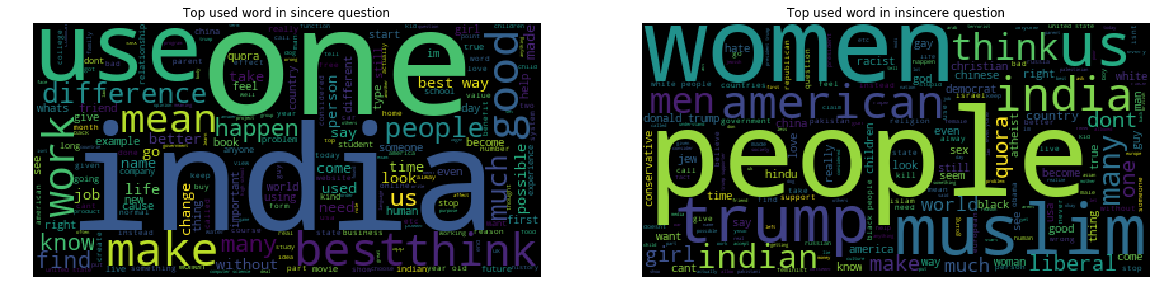

In [0]:
wc_sincere = WordCloud().generate(' '.join(clean_sincere).lower())
wc_insincere = WordCloud().generate(' '.join(clean_insincere).lower())

fig, ax = plt.subplots(1, 2, figsize = (20, 6))

ax[0].imshow(wc_sincere)
ax[0].set_title("Top used word in sincere question")
ax[0].axis('off')

ax[1].imshow(wc_insincere)
ax[1].set_title("Top used word in insincere question")
ax[1].axis('off')
plt.show()

##Building model

## Logistic Regression

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(train['question_text'].values, train['target'].values, test_size = 0.2, random_state = 5)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 10)

In [0]:
tfv = TfidfVectorizer(min_df=3, max_features=None, 
                      strip_accents='unicode', analyzer='word',
                      ngram_range=(1, 3))
tfv.fit(clean_data)
x_train = tfv.transform(X_train)
x_test = tfv.transform(X_test)
x_val = tfv.transform(X_val)

In [7]:
LR = LogisticRegressionCV(penalty = 'l2', solver='lbfgs', max_iter=20, random_state=1)
LR.fit(x_train, Y_train)

def result(x_test, Y_test):
    f1 = metrics.f1_score(y_true = Y_test, y_pred = LR.predict(x_test))
    acc = metrics.accuracy_score(y_true = Y_test, y_pred = LR.predict(x_test))
    return f1, acc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.

In [9]:
f1_train, acc_train = result(x_train, Y_train)
f1_val, acc_val = result(x_val, Y_val) 
f1_test, acc_test = result(x_test, Y_test)

print("F1-score on train set: {}".format(f1_train))
print("Accuracy score on train set: {}".format(acc_train))

print("F1-score on validation set: {}".format(f1_val))
print("Accuracy score on validation set: {}".format(acc_val))

print("F1-score on test set: {}".format(f1_test))
print("Accuracy score on test set: {}".format(acc_test))

F1-score on train set: 0.6148441738778587
Accuracy score on train set: 0.9599166233609628
F1-score on validation set: 0.5556803714521081
Accuracy score on validation set: 0.954575731359053
F1-score on test set: 0.554968287526427
Accuracy score on test set: 0.9548739778887085


##BiLSTM

###Preprocessing question

In [0]:
max_features = 100000
max_len = 70
embedding_dim = 300

In [0]:
def preprocessing(data, get_word_index = False):
    data = list(data['question_text'].values)
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
    tokenizer.fit_on_texts(data)
    sequence = tokenizer.texts_to_sequences(data)
    if get_word_index:
        return tokenizer.word_index
    else:
        return pad_sequences(sequence, maxlen=max_len)

###Embedding

In [0]:
def get_word_index(data):
    data = list(data['question_text'].values)
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ')
    tokenizer.fit_on_texts(data)
    sequence = tokenizer.texts_to_sequences(data)
    return pad_sequences(sequence, maxlen=max_len), tokenizer.word_index

def load_glove(word_index):
    embeddings_index = {}
    with open('glove.6B.300d.txt', encoding='utf8') as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            embeddings_index[word] = coefs

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

def load_fast_text(word_index):
    embeddings_index = {}
    with open('wiki-news-300d-1M.vec', encoding='utf8') as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            embeddings_index[word] = coefs

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = len(embeddings_index)

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.random((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [0]:
pad, word_index = get_word_index(train)
embedding_matrix = load_glove(word_index)

X_train, X_test, Y_train, Y_test = train_test_split(pad, train['target'], test_size = 0.2, random_state = 5)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 15)

400000it [00:26, 14844.05it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


###Training

In [0]:
inp = Input(shape=(max_len,))
outp = Embedding(max_features, embedding_dim, weights=[embedding_matrix], trainable=False)(inp)
outp = Bidirectional(CuDNNLSTM(128, return_sequences=True))(outp)
outp = Bidirectional(CuDNNLSTM(64, return_sequences=True, ))(outp)
outp = Bidirectional(CuDNNLSTM(32, return_sequences=True))(outp)
outp = Dropout(0.2)(outp)
outp = Flatten()(outp)
outp = Dense(512, activation="relu")(outp)
outp = Dropout(0.2)(outp)
outp = Dense(1, activation="sigmoid")(outp)
model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0708 13:09:55.907890 139941577848704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0708 13:09:59.104992 139941577848704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0708 13:09:59.115859 139941577848704 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

In [0]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 300)           30000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 256)           440320    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 128)           164864    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 64)            41472     
_________________________________________________________________
dropout (Dropout)            (None, 70, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 4480)              0     

In [0]:
for i in range(10):
    model.fit(X_train, Y_train, 
              epochs = 1, 
              batch_size=512, 
              validation_data=(X_val, Y_val), 
              shuffle=True,
              callbacks=[ModelCheckpoint('/result.h5',save_best_only=True),
                         EarlyStopping()])
    pred_val_y = model.predict([X_val], batch_size=1024, verbose=0)
    
    best_thresh = 0.5
    best_score = 0.0
    for thresh in np.arange(0.1, 0.501, 0.01):
        thresh = np.round(thresh, 2)
        score = metrics.f1_score(Y_val, (pred_val_y > thresh).astype(int))
        if score > best_score:
            best_thresh = thresh
            best_score = score

    print("Val F1 Score: {:.4f}, Best Threshold: {:.4f}".format(best_score, best_thresh))

Train on 835917 samples, validate on 208980 samples
835917/835917 [==============================] - 148s 177us/sample - loss: 0.1309 - acc: 0.9502 - val_loss: 0.1156 - val_acc: 0.9548
Val F1 Score: 0.6181, Best Threshold: 0.3000
Train on 835917 samples, validate on 208980 samples
835917/835917 [==============================] - 146s 175us/sample - loss: 0.1099 - acc: 0.9569 - val_loss: 0.1090 - val_acc: 0.9570
Val F1 Score: 0.6419, Best Threshold: 0.3300
Train on 835917 samples, validate on 208980 samples
835917/835917 [==============================] - 146s 175us/sample - loss: 0.1029 - acc: 0.9595 - val_loss: 0.1053 - val_acc: 0.9581
Val F1 Score: 0.6564, Best Threshold: 0.3400
Train on 835917 samples, validate on 208980 samples
835917/835917 [==============================] - 146s 175us/sample - loss: 0.0969 - acc: 0.9614 - val_loss: 0.1053 - val_acc: 0.9585
Val F1 Score: 0.6595, Best Threshold: 0.3400
Train on 835917 samples, validate on 208980 samples
835917/835917 [=============

In [0]:
pred_val_y = model.predict([X_test], batch_size=1024, verbose=0)

best_thresh = 0.5
best_score = 0.0
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    score = metrics.f1_score(Y_test, (pred_val_y > thresh).astype(int))
    if score > best_score:
        best_thresh = thresh
        best_score = score

print("Val Accuracy Score: {:.4f}, Best Threshold: {:.4f}".format(best_score, best_thresh))